### Global Climate Projections (NEX-GDDP)

The NEX-GDDP dataset contains 21 climate models under 2 greenhouse gas scenarios. Each of the 42 models forecast daily minumum and maximum temperatures for small grids of about 25km x 25km across the globe up until the year 2099 (about 12TB of data).

For a given plant and NEX model, the GDD is calculated for every day of a year in each grid cell. Then, at every day in each grid cell, the GDD is accumulated for the next 365 days, with the accumulation stopping if the GDD is zero. The given plant is assumed to be able to reach maturity on days where the AGDD is above the maturity threshold. The probability of growth in a cell is the number of NEX models where growth is possible out of all the models.

In this example we compare the performance of accessing the same data using local
access (downloading the file first) vs. using s3fs vs. using Kita.

Cange the first cell ACCESS_TYPE variable to "local"/"s3fs"/"rest" try out the
different access methods.

In [1]:
ACCESS_TYPE="local"  # either "local" or "s3fs" or "rest"

In [2]:
%matplotlib inline
if ACCESS_TYPE == "s3fs":
    import h5py
    import s3fs
elif ACCESS_TYPE == "rest":
    import h5pyd
else:
    from os import path
    import h5py  # assume local
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
if ACCESS_TYPE == "rest":
    ! hsinfo

In [4]:
%%time
s3_folder = "NEX-DCP30/NEX-quartile/rcp85/mon/atmos/tasmin/r1i1p1/v1.0/CONUS/"
filename = "tasmin_quartile75_amon_rcp85_CONUS_209601-209912.nc"
if ACCESS_TYPE == "s3fs":
    filepath = "s3://nasanex/" + s3_folder + filename
elif ACCESS_TYPE == "rest":
    filepath = "/shared/NASA/NEX-DCP30/" + filename
else:
    if not path.isfile(filename):
        object_url = "https://nasanex.s3-us-west-2.amazonaws.com/" + s3_folder + filename
        print(f"downloading file from: {object_url}")
        ! wget {object_url}
    filepath = filename

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 427 µs


In [5]:
%%time
if ACCESS_TYPE == "s3fs":
    s3 = s3fs.S3FileSystem()
    f = h5py.File(s3.open(filepath, "rb"), "r")
elif ACCESS_TYPE == "rest":
    f = h5pyd.File(filepath, "r")
else:
    f = h5py.File(filepath, "r")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 833 µs


In [6]:
for name in f:
    print(f"{name}: {f[name]}")

bnds: <HDF5 dataset "bnds": shape (2,), type ">f4">
lat: <HDF5 dataset "lat": shape (3105,), type "<f8">
lat_bnds: <HDF5 dataset "lat_bnds": shape (3105, 2), type "<f8">
lon: <HDF5 dataset "lon": shape (7025,), type "<f8">
lon_bnds: <HDF5 dataset "lon_bnds": shape (7025, 2), type "<f8">
tasmin: <HDF5 dataset "tasmin": shape (48, 3105, 7025), type "<f4">
time: <HDF5 dataset "time": shape (48,), type "<f8">
time_bnds: <HDF5 dataset "time_bnds": shape (48, 2), type "<f8">


In [7]:
%time f.attrs["version"]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 406 µs


b'1.0'

In [8]:
tasmin = f["tasmin"]
tasmin

<HDF5 dataset "tasmin": shape (48, 3105, 7025), type "<f4">

In [9]:
tasmin.chunks

(1, 369, 836)

In [10]:
# dataset size in MB
4 * tasmin.shape[0] * tasmin.shape[1] * tasmin.shape[2] // 1024**2

3994

In [11]:
# Read a 83MB slice
%time data = tasmin[7,:,:]

CPU times: user 428 ms, sys: 48 ms, total: 476 ms
Wall time: 739 ms


In [12]:
data.min(), data.max(), data.mean()

(271.54395, 1e+20, 4.4463538e+19)

In [13]:
tasmin.fillvalue

9.96921e+36

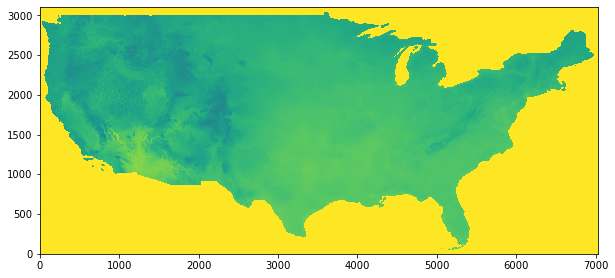

In [14]:
plt.figure(1, figsize=(10,10),dpi=72)
plt.imshow(data, origin="lower", vmin=250, vmax=320)

In [15]:
# do a time series extraction
%time tseries = tasmin[:, 1500, 3000]

CPU times: user 268 ms, sys: 4 ms, total: 272 ms
Wall time: 428 ms


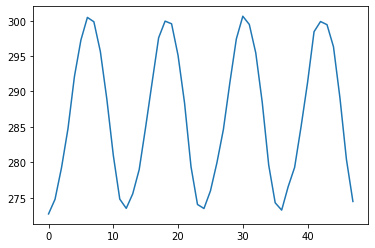

In [16]:
x = range(len(tseries))
plt.plot(x, tseries)